In [1]:
import lasagne
import theano
import theano.tensor as T
import numpy as np
from scipy.io import loadmat
import matplotlib.pylab as plt
%matplotlib inline

Make sure we generate the same data every time by fixing the seed

In [2]:
np.random.seed(42)

Data is 23 sums of sinusoids of random frequency, samples at 100 times in the interval [-100,100]

In [3]:
x = np.linspace(-100,100,100)
n,m = (23,6)
constants = 10*np.pi*np.random.rand(n,m)
x = np.array([sum([np.sin(b*x) for b in a]) for a in constants])

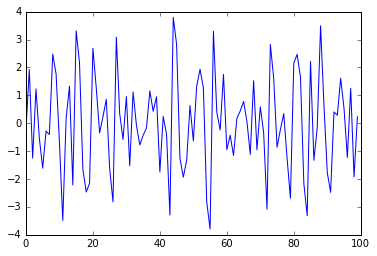

In [4]:
plt.plot(x[5].T);

Lasagne's GRUlayer expects a three-dimensional input (batch_size,seq_len,dimension_of_signal)

In [5]:
X = x[:,None]

In [6]:
X.shape

(23, 1, 100)

In [7]:
X = X.transpose((0,2,1))

The output is supposed to be the next frame

In [8]:
x = X[:,:-1]
y = X[:,1:]

In [9]:
x.shape,y.shape

((23, 99, 1), (23, 99, 1))

Lasagne also requires float32's for some reason (probably to save space)

In [10]:
x = x.astype(np.float32)
y = y.astype(np.float32)

Since Lasagne won't work with singular hidden units, the model has two, but we only use one in the cost function.

In [11]:
NUM_INPUTS = 1
NUM_UNITS_ENC = 30

In [12]:
#symbolic theano variables. Note that we are using imatrix for X since it goes into the embedding layer
x_sym = T.matrix()

In [13]:
x_sym = T.ftensor3()
y_sym = T.ftensor3()

First we try with a batch size of one, to test the code with long waiting times

In [14]:
x_first = x[0:10,:].astype(np.float32)
y_first = y[0:10,:].astype(np.float32)

In [15]:
x_first.shape,y_first.shape

((10, 99, 1), (10, 99, 1))

In [18]:
l_in = lasagne.layers.InputLayer((None,None,1), input_var = x_sym)
batch_size,seq_len,_ = l_in.input_var.shape
l_enc1 = lasagne.layers.GRULayer(l_in, num_units=NUM_UNITS_ENC, name='GRUEncoder')
l_enc2 = lasagne.layers.GRULayer(l_enc1, num_units=NUM_UNITS_ENC, name='GRUEncoder')
l_reshape = lasagne.layers.reshape(l_enc2, (-1,NUM_UNITS_ENC))
l_dense = lasagne.layers.DenseLayer(l_reshape,1,nonlinearity=lasagne.nonlinearities.linear)
l_out = lasagne.layers.reshape(l_dense, (batch_size,seq_len,1))
# make sure output layer's range matches the range of input, fx with linear output layer
print(lasagne.layers.get_output(l_in, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_enc1, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_enc2, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_reshape, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_dense, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)
print(lasagne.layers.get_output(l_out, inputs={l_in: x_sym}).eval({x_sym: x_first}).shape)

(10, 99, 1)
(10, 99, 30)
(10, 99, 30)
(990, 30)
(990, 1)
(10, 99, 1)


In [19]:
# cost function is mean absolute difference between predicted and actual next step.
predicted_values = lasagne.layers.get_output(l_out)
cost = T.mean(abs(predicted_values - y_sym))

In [20]:
cost.eval({x_sym: x_first,y_sym: y_first})

array(1.3353089066043313)

In [21]:
all_parameters = lasagne.layers.get_all_params([l_out], trainable=True)
#add grad clipping to avoid exploding gradients
all_grads = [T.clip(g,-3,3) for g in T.grad(cost, all_parameters)]
#updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.001)
updates = lasagne.updates.adam(all_grads, all_parameters, learning_rate=0.005)

In [22]:
print("Trainable Model Parameters")
print("-"*40)
for param in all_parameters:
    print(param, param.get_value().shape)
print("-"*40)

Trainable Model Parameters
----------------------------------------
GRUEncoder.W_in_to_updategate (1, 30)
GRUEncoder.W_hid_to_updategate (30, 30)
GRUEncoder.b_updategate (30,)
GRUEncoder.W_in_to_resetgate (1, 30)
GRUEncoder.W_hid_to_resetgate (30, 30)
GRUEncoder.b_resetgate (30,)
GRUEncoder.W_in_to_hidden_update (1, 30)
GRUEncoder.W_hid_to_hidden_update (30, 30)
GRUEncoder.b_hidden_update (30,)
GRUEncoder.W_in_to_updategate (30, 30)
GRUEncoder.W_hid_to_updategate (30, 30)
GRUEncoder.b_updategate (30,)
GRUEncoder.W_in_to_resetgate (30, 30)
GRUEncoder.W_hid_to_resetgate (30, 30)
GRUEncoder.b_resetgate (30,)
GRUEncoder.W_in_to_hidden_update (30, 30)
GRUEncoder.W_hid_to_hidden_update (30, 30)
GRUEncoder.b_hidden_update (30,)
W (30, 1)
b (1,)
----------------------------------------


In [23]:
# compile training function (in C or somesuch)
train_func = theano.function([x_sym, y_sym], [cost, predicted_values], updates=updates)

In [24]:
c = 0
csts = []
preds = []
num_epochs = 3000
while c < num_epochs:
    cst, pred = train_func(x,y)
    csts.append(cst)
    preds.append(pred)
    c += 1
    #print(c)

In [25]:
while c < num_epochs*2:
    cst, pred = train_func(x,y)
    csts.append(cst)
    preds.append(pred)
    c += 1
    #print(c)

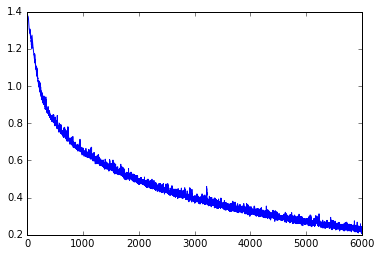

In [26]:
plt.plot(csts);

In [27]:
print(csts[-1])

0.22523676439821116


Compare prediction generated by a randomly initialized network

In [28]:
preds[0].shape

(23, 99, 1)

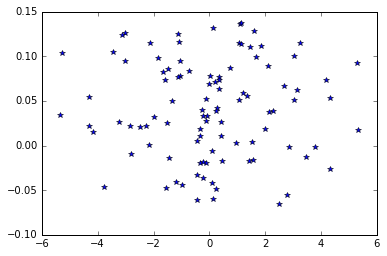

In [29]:
plt.plot(y_first[0,:,0].T.flatten(),preds[0][0,:,0].T.flatten(),'*')

to prediction by trained network (ideal is a straight line)

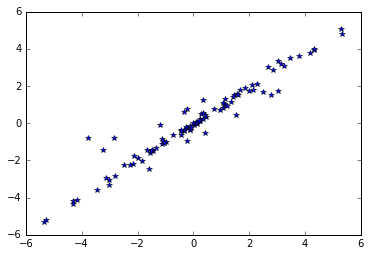

In [30]:
plt.plot(y_first[0,:,0].T.flatten(),preds[-1][0,:,0].T.flatten(),'*');

A few sample sequence comparisons:

In [31]:
sequence_idxs = np.random.choice(10,9,replace=False)

In [32]:
plt.rcParams['figure.figsize'] = (20,20)

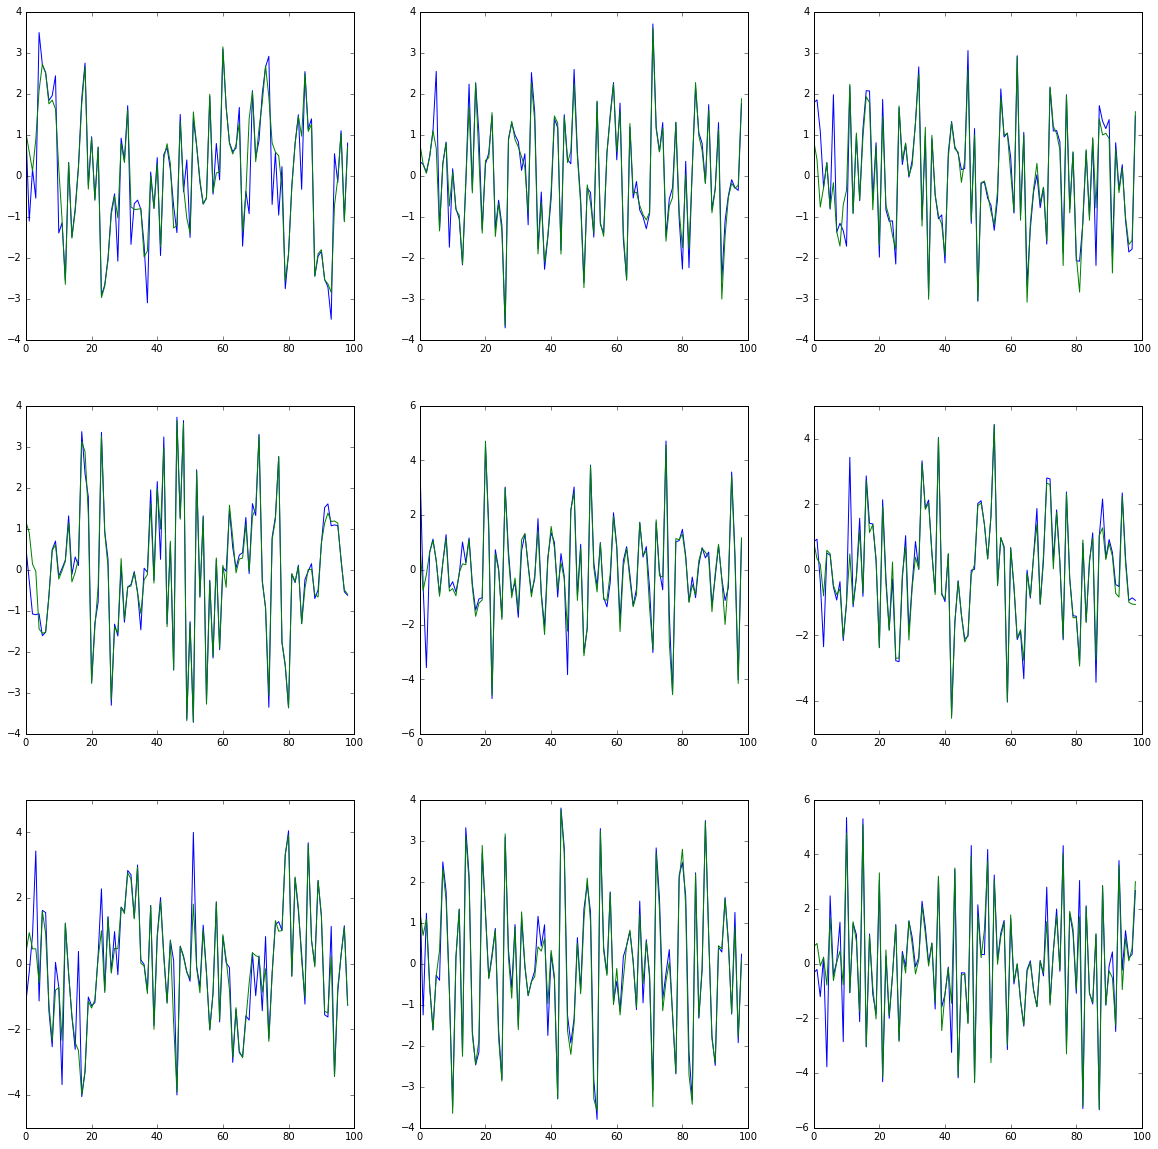

In [33]:
cc = 0
for i in sequence_idxs:
    cc += 1
    plt.subplot(3,3,cc)
    plt.plot(y_first[i,:,0].T)
    plt.plot(preds[-1][i,:,0].T)